In [1]:
import numpy as np

class Colors():

	def _general_color(self, color, dtype):
		
		if dtype == 'float':
			return [float(i) for i in color]

		elif dtype == 'np.uint8':
			return np.array(
				[color[0], color[1], color[2]], np.uint8)

		else:
			return color

	#BROWNS

	def chocolate_silk(self, dtype='int'):

		color = (49,17,4)
		
		return self._general_color(color, dtype)

	def deep_brown(self, dtype='int'):

		color = (20,8,2)
		
		return self._general_color(color, dtype)

	#BLUES

	def midnight(self, dtype='int'):

		color = (1,15,23)
		
		return self._general_color(color, dtype)

	def blueberry_slate(self, dtype='int'):

		color = (6,56,82)
		
		return self._general_color(color, dtype)


	#TURQOUISE

	def turquoise(self, dtype='int'):
		
		color = (120,192,168)

		return self._general_color(color, dtype)


	def tiffany(self, dtype='int'):
		
		color = (82,183,189)

		return self._general_color(color, dtype)

		82, 183, 189

	#OFF-WHITE

	def bone(self, dtype='int'):
		
		color = (225,235,182)

		return self._general_color(color, dtype)

	#ORANGE

	def orange_gold(self, dtype='int'):
		
		color = (240,168,48)

		return self._general_color(color, dtype)

	def tangerine(self, dtype='int'):
		
		color = (240,129,15)

		return self._general_color(color, dtype)

	#YELLOW

	def sick_yellow(self, dtype='int'):
		
		color = (230,223,68)

		return self._general_color(color, dtype)

	#RED

	def red(self, dtype='int'):
		
		color = (255,0,0)

		return self._general_color(color, dtype)


	#WHITE

	def white(self, dtype='int'):
		
		color = (255,255,255)

		return self._general_color(color, dtype)

	def ivory(self, dtype='int'):
		
		color = (255,255,240)

		return self._general_color(color, dtype)

In [2]:

import time
import random
import numpy as np
import math as m
from scipy import ndimage
import cv2
import itertools
import torch

import torch.multiprocessing as mp
import kogers_colors 


from individual import Individual
from rotate import rotate

from __future__ import division


#kc = kogers_colors.Colors()
kc = Colors()

def close_cv2():
    for ind in range(10):
        cv2.destroyAllWindows()
        cv2.waitKey(1)

# differentiable equivalent of np.where
# cond could be a FloatTensor with zeros and ones

def where(cond, x_1, x_2):
    ones = cond.clone().zero_() + 1
    return (cond * x_1) + ((ones-cond) * x_2)
 
EPSILON = .0000001
    
class Simulation():
    
    def __init__(self, num_agents=400, number_of_states=2, arena_size=1000,
                 max_turning_rate=114.5, body_size=4.0, zoa=12.0,
                 zor=2.0, zoo=12.0, speed=10, angular_error_sd=0.0, 
                 ko=0.25, ka=0.25, periodic_boundary=True,
                 draw_sim=True, state_threshold=0.5, num_active=.5,
                 omega=.5, video=False, video_file='testvid.avi',
                 social_weight=0.85, number_of_cells=2, cuda=False,
                 noise_sd=.1, movement='schooling', record_states=False):
        
        
        self.FloatTensor = torch.FloatTensor
        self.IntTensor = torch.IntTensor
        
        self.cuda = cuda
        if self.cuda:
            self.FloatTensor = torch.cuda.FloatTensor 
            self.IntTensor = torch.cuda.IntTensor 
            
        self.movement = movement
        
        self.num_agents = int(num_agents)
        self.number_of_states = int(number_of_states)
        self.arena_size = int(arena_size)
        self.max_turning_rate = max_turning_rate
        self.body_size = body_size
        self.zoa = zoa * body_size
        self.zor = zor * body_size
        self.zoo = zoo * body_size
        self.speed = speed
        self.angular_error_sd = angular_error_sd
        self.ko = ko
        self.ka = ka
        self.noise_sd = noise_sd
        
        self.top_left = np.zeros(2)
        self.bottom_right = np.ones(2) * arena_size
        self.number_of_cells = int(number_of_cells)
        self.next_number_of_cells = int(number_of_cells)
        self.cell_size = arena_size / self.number_of_cells
        self.total_cells = self.number_of_cells ** 2
        
        self.agents = self.generate_agents()
        
        self.periodic_boundary = periodic_boundary
        
        self.draw_sim = draw_sim
        self.state_threshold = state_threshold
        self.num_active = int(num_agents * num_active)
        self.video = video
        self.video_file = video_file
        if self.video:
            print('Video initialized...')
            self.out = self.initialize_video()
        else:
            self.out = None 
        
        self.social_weight = self.FloatTensor([social_weight])
        self.omega = self.FloatTensor([omega])
            
        self.state = None
        
        self.record_states = record_states
        self.all_states = np.ones((1, self.num_agents))
        
        #output of the video recorder, if enabled
        
    def initialize_video(self):
        fourcc = cv2.VideoWriter_fourcc(*'ffv1')
        out = cv2.VideoWriter(filename=self.video_file, fourcc=fourcc, fps=30, 
                              frameSize=(int(self.arena_size), int(self.arena_size)), isColor=True)
        return out

    def create_mask(self, r, inner_r, outer_r):
        """Return a mask that is False if distance is within the specified range

        arguments:
        r -- matrix containg distances between all individuals: shape() = (n,m)
        inner_r -- minimum distance (exclusive)
        outer_r -- maximum distance (exclusive)

        return matrix shape = (n,m,2)
        """
        mask = (r > inner_r) * (r < outer_r) * -1 + 1
        mask = torch.unsqueeze(mask, 2)
        mask = mask.repeat(1,1,2)
        return(mask)
    
    def create_state_mask(self, r, inner_r, outer_r):
        """Return a mask that is False if distance is within the specified range

        arguments:
        r -- matrix containg distances between all individuals: shape() = (n,m)
        inner_r -- minimum distance (exclusive)
        outer_r -- maximum distance (exclusive)

        return matrix shape = (n,m)
        """
        mask = (r >= inner_r) * (r < outer_r) * -1 + 1
        return(mask)

    def zone_vec_v(self, expanded_val, mask):
        """Apply mask to velocities calculate social alignment
        """
        vals = expanded_val.repeat(1, mask.size()[1], 1)
        #take term from vals where mask is true and from zeros when false
        
        vals = vals.masked_fill_(mask, 0.0)
        return(torch.sum(vals, 0))

    def zone_vec_state(self, expanded_val, mask):
        """Apply mask to velocities calculate social alignment
        """
        vals = expanded_val.repeat(1, mask.size()[1])
        #take term from vals where mask is true and from zeros when false
        vals = vals.masked_fill_(mask, 0.0)
        return(torch.sum(vals, 0))

    def zone_vec_x(self, rel_pos, mask):
        #take term from rel_pos where mask is true and from zeros when false
        vals = rel_pos.masked_fill_(mask, 0.0)
        return(torch.sum(vals, 0))
    
    def assign_new_values(self,id_individual):
        self.agents[id_individual].r_center = self.xnew_cpu[id]
        self.agents[id_individual].direction = self.vnew_cpu[id]
        self.agents[id_individual].state = self.state_cpu[id]
        
    def generate_agents(self):

        agents = []
        
        for indx_agents in range(self.num_agents):
            # needs to be a unit vector
            set_direction = np.array([1.0, 0.0])    
            set_direction = rotate(set_direction, random.random()*360.0)
            set_r_center = self.random_bounded_point()
            state = np.random.choice(np.arange(self.number_of_states)).astype(np.float) + 1.0
            
            agents.append(
                Individual(set_r_center, set_direction, self.max_turning_rate,
                           self.speed, self.zoa, self.zoo, self.zor, self.angular_error_sd, 
                           self.body_size, state, self.ko, self.ka))
        return agents
    
    def random_bounded_point(self):

        # Create randomly distributed co-ordinate in the simulated world
        range_x = self.bottom_right[0] - self.top_left[0]
        range_y = self.bottom_right[1] - self.top_left[1]

        random_x = random.random()
        random_y = random.random()

        random_x *= range_x
        random_y *= range_y
        random_point = np.array([random_x, random_y])

        return random_point
        


    def segment_individuals(self):

        # this implementation assumes equal x and y 
        
        self.cell_to_agents = [[] for x in range(self.total_cells)]
        self.cell_to_positions = [[] for x in range(self.total_cells)]
        self.cell_to_velocities = [[] for x in range(self.total_cells)]
        self.cell_to_states = [[] for x in range(self.total_cells)]
        number_agents_in_cell = [0 for x in range(self.total_cells)]
        cell_x = 0
        cell_y = 0
        if self.record_states:
            current_state = np.ones((1, self.num_agents))

        for agent_id in range(self.num_agents):
            
            if self.record_states:
                current_state[0,agent_id] = self.agents[agent_id].state
            # cell_x and cell_y determine which cell agents is in
            cell_x = self.agents[agent_id].r_center[0] // self.cell_size
            cell_y = self.agents[agent_id].r_center[1] // self.cell_size

            #calculate scalar cell id
            cell = int(cell_x * self.number_of_cells + cell_y)                      
            self.cell_to_agents[cell].append(agent_id) 
            self.cell_to_positions[cell].append(self.agents[agent_id].r_center)
            self.cell_to_velocities[cell].append(self.agents[agent_id].direction)
            self.cell_to_states[cell].append(self.agents[agent_id].state)
            number_agents_in_cell[cell] += 1

        if self.cuda:
            if max(number_agents_in_cell) > 600:
                self.next_number_of_cells = self.number_of_cells + 1
            if max(number_agents_in_cell) < 200:
                self.next_number_of_cells = self.number_of_cells - 1
            if self.next_number_of_cells < 1:
                self.next_number_of_cells = 1 
        
        self.all_states = np.concatenate((self.all_states, current_state), 0)


            
    def neighbor_tensor(self, list_names, cell): 
        """list_names should be a list containing the lists of the various particle atributes:
        for example [self.cell_to_positions] or [self.cell_to_positions, self.cell_to_velocities]
        
        returns list where each entry is the neighbor tensor for each atribute in list_names
        """
        cells = [[] for _ in range(len(list_names))]

        bottom = (cell % self.number_of_cells == self.number_of_cells - 1)
        top = (cell % self.number_of_cells == 0)
        left = (cell < self.number_of_cells)
        right = (cell >= self.number_of_cells * (self.number_of_cells - 1))

        for x in range(-1,2):
            for y in range(-1,2):
                x_adjusted = x
                y_adjusted = y

                if bottom and y == 1:
                    x_adjusted -= 1
                if top and y == -1:
                    x_adjusted += 1

                neighbor_cell = cell + x_adjusted * self.number_of_cells + y_adjusted
                
                if right and x == 1:
                    neighbor_cell -= self.total_cells
                if left and x == -1:
                    neighbor_cell += self.total_cells
                for list_num, list_name in enumerate(list_names):
                    #print('type ', type(neighbor_cell))
                    neighbor_cell_values = torch.FloatTensor(list_name[neighbor_cell]) 
                    #only work on cells that aren't empty
                    if neighbor_cell_values.size():
                        if list_name is self.cell_to_positions:
                            if top and y == -1:
                                neighbor_cell_values[:,1] -= self.arena_size
                            if bottom and y == 1:
                                neighbor_cell_values[:,1] += self.arena_size
                            if left and x == -1:
                                neighbor_cell_values[:,0] -= self.arena_size
                            if right and x == 1:
                                neighbor_cell_values[:,0] += self.arena_size

                    cells[list_num].append(neighbor_cell_values)

        if self.cuda:       
            return [torch.cat(cells[list_num]).pin_memory().cuda() for list_num in range(len(list_names))]
        else:
            return [torch.cat(cells[list_num]) for list_num in range(len(list_names))]

    
    def resize_cells(self):
        if self.number_of_cells != self.next_number_of_cells: 
            self.number_of_cells = self.next_number_of_cells
            self.cell_size = self.arena_size / self.number_of_cells
            self.total_cells = self.number_of_cells ** 2
            

    def get_agents(self):
        return self.agents

            
    def calculate_new_states(self, cell_num, neighbor_distances):

        state_neighbors = self.neighbor_tensor([self.cell_to_states], cell_num)[0]
        
        zos_r = self.FloatTensor([12.0]) * self.FloatTensor([self.agents[0].body_size]) 
        
        neighbor_mask = self.create_state_mask(neighbor_distances, 0.0, zos_r) 
        neighbor_mask = torch.unsqueeze(neighbor_mask, 2)

        #make same dimension as mask
        state_neighbors = torch.unsqueeze(state_neighbors, 1)
        state_neighbors = torch.unsqueeze(state_neighbors, 2)
        state_neighbors = state_neighbors.repeat(1, neighbor_mask.size()[1], 1)
        #only keep values within correct distance 
        state_neighbors = state_neighbors.masked_fill_(neighbor_mask, 0.0)
        #replicate so number of states tall
        state_neighbors = state_neighbors.repeat(1, 1, self.number_of_states)
        
        state_list = torch.arange(1, self.number_of_states + 1)

        state_count = torch.eq(state_neighbors, state_list)
        state_count = torch.sum(state_count, 0)
        
        state_list = torch.unsqueeze(state_list, 0)
        states = state_list.repeat(neighbor_mask.size()[1], 1)

        #the most counted state amoung individual's neighbors
        max_states, _ = torch.max(state_count, 1)
        max_states = torch.unsqueeze(max_states, 1)
        max_states = max_states.repeat(1, self.number_of_states)

        #Find all the states that have the maximum count (could be multiple because of ties)
        max_states_mask = (state_count==max_states).type(torch.FloatTensor)
        #Number of states that have the highest count (again could be ties)
        num_possible_states = torch.sum(max_states_mask, 1)
        cum_possible_states = torch.cumsum(num_possible_states, 0)
        rand = torch.rand(neighbor_mask.size()[1])
        rand_ind = torch.ceil((num_possible_states * rand).type(torch.FloatTensor))
        new_state_ind = cum_possible_states - rand_ind

        possible_states_ind = torch.nonzero(max_states_mask * states)
        possible_states = states[possible_states_ind[:,0], possible_states_ind[:,1]]
        

        try:
            self.state = possible_states[new_state_ind.type(torch.LongTensor)]
        except:
            print('issue')
            print('max_states_mask: ', max_states_mask)
            print('num_possible_states:', num_possible_states)
            print('cum_possible_states:', cum_possible_states)
            print('rand_ind: ', rand_ind)
            print('possible_states_ind: ', possible_states_ind)
            print('possible states: ', possible_states )
            print('new_state_ind: ', new_state_ind.type(torch.LongTensor))
        
        state_cpu = self.state.cpu()
        
        states_converged = True
        
        for index, agent_id in enumerate(self.id):
            if self.agents[agent_id].state == state_cpu[index]:
                self.agents[agent_id].same = True
            else:
                self.agents[agent_id].same = False
                states_converged = False

            self.agents[agent_id].state = state_cpu[index]
        
        return states_converged
                    

       
    def move_schooling(self, neighbor_distances, rx, v_neighbors):
        expanded_v1 = torch.unsqueeze(self.v, 0)
        expanded_v2 = torch.unsqueeze(v_neighbors, 1)
        
        # To avoid division by zero make min distance
        #larger then 0 this add to prevent simulation 
        #explosion if particles get too close
        neighbor_distances = torch.clamp(neighbor_distances, min=0.00002) 

        body_size = self.FloatTensor([self.agents[0].body_size])

        # radius of zone of alignment
        zor_r = self.FloatTensor([2.0]) * body_size
        # radius of zone of alignment
        zoo_r = self.FloatTensor([12.0]) * body_size
        # radius of zone of alignment
        zoa_r = self.FloatTensor([12.0]) * body_size 

        #torch.cuda.synchronize()

        r_expanded = torch.unsqueeze(neighbor_distances, 2)
        r_expanded = r_expanded.repeat(1, 1, 2)
        r_unit = rx / r_expanded  

        #torch.cuda.synchronize()

        zor_mask = self.create_mask(neighbor_distances, 0.0, zor_r) 
        zor_x = self.zone_vec_x(r_unit, zor_mask)
        zor_sum = torch.sum(torch.abs(zor_x), 1)
        mask_zor_full = (zor_sum > self.FloatTensor([0.0])).type(self.FloatTensor)
        mask_zor_full = torch.unsqueeze(mask_zor_full,1)
        mask_zor_full = mask_zor_full.repeat(1, 2)

        #torch.cuda.synchronize()

        zoo_mask = self.create_mask(neighbor_distances, zor_r, zoo_r)
        zoo_v = self.zone_vec_v(expanded_v2, zoo_mask)
        #zoo_v = zoo_v * self.FloatTensor([1.0])  #3

        #torch.cuda.synchronize()

        zoa_mask = self.create_mask(neighbor_distances, zoo_r, zoa_r)
        zoa_x = self.zone_vec_x(r_unit, zoa_mask)
        zoa_x = zoa_x * self.FloatTensor([-1.0])

        #torch.cuda.synchronize()    

        zoa_zoo = torch.sum(zoa_x, 1) * torch.sum(zoo_v,1)
        mask_both_zones = zoa_zoo > self.FloatTensor([0.0])

        #torch.cuda.synchronize()

        #should be 0 if only one zone has individuals, 1 if both
        both_zones = mask_both_zones.type(self.FloatTensor)
        both_zones_expanded = torch.unsqueeze(both_zones, 1)
        both_zones_expanded = both_zones_expanded.repeat(1,2)

        point_five_vec = both_zones_expanded.clone().zero_() + .5
        #.pow was cast to float before in tf
        outer_zones_v = torch.pow(point_five_vec, both_zones_expanded) * (zoa_x + zoo_v) 

        vnew = where(mask_zor_full, zor_x, outer_zones_v)
        vnew = torch.clamp(vnew, max=100000.0) #so speed can't blow up
        return vnew
    
    def move_straight(self):
        return self.v
    
#     def move_random(self):
#         return 

        
    def main_graph(self):
        
        states_converged = True

        for cell_num in range(self.total_cells):
            
            if self.cuda:
                self.x = torch.FloatTensor(self.cell_to_positions[cell_num]).pin_memory().cuda()
                self.v = torch.FloatTensor(self.cell_to_velocities[cell_num]).pin_memory().cuda()
                self.id = torch.IntTensor(self.cell_to_agents[cell_num]).pin_memory().cuda()
            else:
                self.x = self.FloatTensor(self.cell_to_positions[cell_num])
                self.v = self.FloatTensor(self.cell_to_velocities[cell_num])
                self.id = self.IntTensor(self.cell_to_agents[cell_num])
                
            #the cell has individuals       
            if self.x.size():
            
                #torch.cuda.synchronize()

                expanded_x1 = torch.unsqueeze(self.x, 0)  

                x_neighbors, v_neighbors = self.neighbor_tensor(
                    [self.cell_to_positions, self.cell_to_velocities], cell_num) 

                expanded_x2 = torch.unsqueeze(x_neighbors, 1)

                #distance based calculations
                #Distance between every pair of particles in x in every dimension (dx,dy)
                rx = expanded_x1 - expanded_x2 
                # square distane for each particle pair in each dimension  (dx^2,dx^2)
                rx2 = rx ** 2
                # absolute square distance between every pair of particles(dx^2+dx^2)
                r2 = torch.sum(rx2, 2)
                # absolute distance between every pair of particles
                r = torch.sqrt(r2)

                #torch.cuda.synchronize()
                if self.movement == 'schooling':
                    vnew = self.move_schooling(r, rx, v_neighbors) 
                else:
                    vnew = self.move_straight()

                personal_weight = self.FloatTensor([1]) - self.social_weight

                vnew = self.social_weight*vnew + personal_weight*self.v
                
                if self.noise_sd > 0.0:
                    vnew += torch.normal(vnew*0.0, self.noise_sd)

                #vnew = ((1 - self.omega)*vnew + self.omega*self.personal_bias)

                #torch.cuda.synchronize()

                #vnew = ((1 - self.omega)*vnew + self.omega*self.personal_bias)

                vnew_mag = vnew ** 2
                vnew_mag = torch.sum(vnew_mag, 1) 
                vnew_mag = torch.sqrt(vnew_mag)
                vnew_mag = torch.clamp(vnew_mag, min=0.0002)
                vnew_mag = torch.unsqueeze(vnew_mag, 1)
                vnew_mag = vnew_mag.repeat(1, 2) 
                vnew = vnew / vnew_mag

                #vnew = self.v
                #here uses global speed, could also be changed to use individuals speed
                xnew = self.x + vnew*self.speed

                #if repetitive boundary conditions are used make sure particle 
                #poistion dont exceed cell size
                if self.periodic_boundary:
                    xnew=torch.fmod(xnew + self.arena_size, self.arena_size)

                if not self.calculate_new_states(cell_num, r):
                    states_converged = False

                xnew_cpu = xnew.cpu().numpy().astype(dtype='float64')
                vnew_cpu = vnew.cpu().numpy().astype(dtype='float64')
                

                for index, agent_id in enumerate(self.id):
                    self.agents[agent_id].r_center = xnew_cpu[index]
                    self.agents[agent_id].direction = vnew_cpu[index]
        
        if self.cuda:
            self.resize_cells()
            
        return states_converged


#     def run_sim(self):
#         WITH_TIMER = False
#         arena_size_int = int(self.arena_size)
        
#         if self.video:
#             self.out = self.initialize_video()

#         for i in range(100000):   
#             [self.positions, self.velocities, self.init_state] = (
#                 session.run([self.xnew,self.vnew,self.state_new],feed_dict = {
#                     self.x: self.positions, 
#                     self.v: self.velocities,
#                     self.state: self.init_state}))
#         #----------------------Plot particles position real time---------------------------------------------       
#             if (i%2==0) and (self.draw_sim==True or self.video==True):
#                 self.draw(arena_size_int)
#                 if cv2.waitKey(1) & 0xFF == 27:
#                     break  #time delay
#             sum_state = np.sum(self.init_state, 0) / self.num_agents
#             if sum_state == 0 or sum_state == 1:
#                 break
#         if self.video:
#             self.out.release()
#         session.close() 
#         cv2.destroyAllWindows() 
#         return sum_state[0]
    
            
    def graphics(self):

        body_scale = .75
        colors = [kc.red(), kc.ivory(), kc.sick_yellow(), kc.tiffany(), kc.orange_gold()]
        
        visualization = (np.ones((self.arena_size, self.arena_size, 3), np.uint8) *
                         kc.blueberry_slate('np.uint8'))

        for i in range(len(self.agents)):
            #-1 because state starts at 1, not zero
            color = colors[int(self.agents[i].state) - 1]
            position = tuple(self.agents[i].r_center.astype(int))
            scaled_body_size = self.agents[i].body_size * body_scale
            
            cv2.circle(visualization, position, 
                       int(scaled_body_size), 
                       color, -1, cv2.LINE_AA)

            cv2.line(visualization, position, 
                     tuple((position - self.agents[i].direction * 3 *
                          scaled_body_size).astype(int)), 
                     color, 1, cv2.LINE_AA)
            
        visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB) 
        
        #t = time.time()
        cv2.imshow("decision_making", visualization)
        #print('imshow: ' , time.time() - t)
        if self.video:
            visualization = (visualization).astype('u1')
            self.out.write(visualization)
        
        return (cv2.waitKey(1) & 0xFF == 27)
    





In [3]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from tqdm import tnrange, tqdm_notebook
from IPython.display import display
import datetime


random.seed()

dataframe_columns = ['Simulation_number', 'Number_of_agents', 'Arena_size', 'Movement',
                     'Speed', 'Number_of_states', 'Noise_SD', 'Number_of_cells', 
                     'Body_size', 'Max_steps', 'Steps', 'Converged', 'Convergence_threshold', 
                     'State_1', 'State_2', 'State_3', 'State_4', 'State_5', 'Record_states']

simulation_results = pd.DataFrame(columns=dataframe_columns)


total_number_of_states = 4
number_of_replicates = 3
number_of_movements = 3
record_states = True

max_steps = 4000

for replicate_number in range(number_of_replicates):
    for current_states in range(total_number_of_states):
        number_of_states = 2 + current_states
        for movement in range(number_of_movements):
            simulation_number = (replicate_number * total_number_of_states * number_of_movements +
                                 current_states * number_of_movements + movement)
            if movement == 0:
                movement = 'schooling'
                noise_sd = 1.0
            elif movement == 1:
                movement = 'straight'
                noise_sd = 0.0
            else:
                movement = 'straight'
                noise_sd = 10.0
             


            simulation_results.loc[simulation_number] = {'Simulation_number': simulation_number, 
                                                        'Number_of_agents': 200, 
                                                        'Arena_size': 300, 
                                                        'Movement': movement,
                                                        'Speed': 3,
                                                        'Number_of_states': number_of_states, 
                                                        'Noise_SD': noise_sd, 
                                                        'Number_of_cells': 3, 
                                                        'Body_size': 3.0,
                                                        'Max_steps': max_steps,
                                                        'Steps': 'None',
                                                        'Converged': 'None',
                                                        'Convergence_threshold': 100,
                                                        'State_1': 'None',
                                                        'State_2': 'None',
                                                        'State_3': 'None',
                                                        'State_4': 'None',
                                                        'State_5': 'None',
                                                        'Record_states': record_states}
    
print('Beginning to run simulations...')

draw = False
kill = False


for sim_number in tnrange(simulation_results.shape[0], desc='All simulations'):

    simulation = Simulation(num_agents=simulation_results.at[sim_number, 'Number_of_agents'],
                            arena_size=simulation_results.at[sim_number, 'Arena_size'],
                            number_of_cells=simulation_results.at[sim_number, 'Number_of_cells'], 
                            body_size=simulation_results.at[sim_number, 'Body_size'],
                            movement=simulation_results.at[sim_number, 'Movement'],
                            video=False, 
                            speed=simulation_results.at[sim_number, 'Speed'], 
                            number_of_states = simulation_results.at[sim_number, 'Number_of_states'],
                            noise_sd = simulation_results.at[sim_number, 'Noise_SD'],
                            record_states = simulation_results.at[sim_number, 'Record_states'])
    

    sim_converged = False
    #for step in tnrange(int(simulation_results.at[sim_number, 'Max_steps']), desc='Simulation ' + str(sim_number)):
    for step in range(int(simulation_results.at[sim_number, 'Max_steps'])):    
        simulation.segment_individuals()
        step_converged = simulation.main_graph()
        
        if step_converged:
            convergence_count += 1
        else:
            convergence_count = 0

        if draw and step % 5 == 0:
            kill = simulation.graphics()

        if kill or convergence_count > int(simulation_results.at[sim_number, 'Convergence_threshold']):
            sim_converged = True
            close_cv2()
            break
            
        if record_states:
            file_name = ('results/states/' + 
                         'num_states_' + str(simulation_results.at[sim_number, 'Number_of_states']) +
                         '_num_agents_' + str(simulation_results.at[sim_number, 'Number_of_agents']) +
                         '_movement_' + str(simulation_results.at[sim_number, 'Movement']) +
                         '_noiseSD_' + str(simulation_results.at[sim_number, 'Noise_SD']) +
                         '_trial_' + str(sim_number // (total_number_of_states *number_of_movements)) + 
                         '.npy')
            np.save(file_name, simulation.all_states)
            simulation_results.loc[sim_number, 'Record_states'] = file_name
    agents = simulation.get_agents()
    agents_states = [a.state for a in agents]
    if sim_converged:
        sim_converged = agents_states[0]
    agents_states, bins = np.histogram(
        agents_states, list(range(1, int(simulation_results.at[sim_number, 'Number_of_states'] + 2))))

    simulation_results.loc[sim_number, ['Steps', 'Converged']] = [step, sim_converged]
    states_list = ['State_'+str(state+1) for state in range(int(simulation_results.at[sim_number, 'Number_of_states']))]
    simulation_results.loc[sim_number, states_list] = agents_states
    

close_cv2()  

now = datetime.datetime.now()
simulation_results.to_pickle('results/' + str(now.isoformat()) + '.pkl')

Beginning to run simulations...


In [4]:
simulation_results

,Simulation_number,Number_of_agents,Arena_size,Movement,Speed,Number_of_states,Noise_SD,Number_of_cells,Body_size,Max_steps,Steps,Converged,Convergence_threshold,State_1,State_2,State_3,State_4,State_5,Record_states
0,0.0,200.0,300.0,schooling,3.0,2.0,1.0,3.0,3.0,4000.0,3999,False,100.0,56,144,None,None,None,results/states/num_states_2.0_num_agents_200.0...
1,1.0,200.0,300.0,straight,3.0,2.0,0.0,3.0,3.0,4000.0,139,2,100.0,0,200,None,None,None,results/states/num_states_2.0_num_agents_200.0...
2,2.0,200.0,300.0,straight,3.0,2.0,10.0,3.0,3.0,4000.0,2227,2,100.0,0,200,None,None,None,results/states/num_states_2.0_num_agents_200.0...
3,3.0,200.0,300.0,schooling,3.0,3.0,1.0,3.0,3.0,4000.0,3999,False,100.0,90,33,77,None,None,results/states/num_states_3.0_num_agents_200.0...
4,4.0,200.0,300.0,straight,3.0,3.0,0.0,3.0,3.0,4000.0,225,2,100.0,0,200,0,None,None,results/states/num_states_3.0_num_agents_200.0...
5,5.0,200.0,300.0,straight,3.0,3.0,10.0,3.0,3.0,4000.0,1913,1,100.0,200,0,0,None,None,results/states/num_states_3.0_num_agents_200.0...
6,6.0,200.0,300.0,schooling,3.0,4.0,1.0,3.0,3.0,4000.0,1975,2,100.0,0,200,0,0,None,results/states/num_states_4.0_num_agents_200.0...
7,7.0,200.0,300.0,straight,3.0,4.0,0.0,3.0,3.0,4000.0,208,4,100.0,0,0,0,200,None,results/states/num_states_4.0_num_agents_200.0...
8,8.0,200.0,300.0,straight,3.0,4.0,10.0,3.0,3.0,4000.0,1604,3,100.0,0,0,200,0,None,results/states/num_states_4.0_num_agents_200.0...
9,9.0,200.0,300.0,schooling,3.0,5.0,1.0,3.0,3.0,4000.0,290,5,100.0,0,0,0,0,200,results/states/num_states_5.0_num_agents_200.0...


/Users/benkoger/Virtualenvs/coding-py3/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


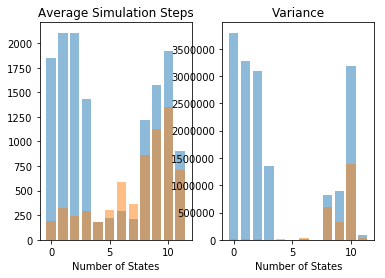

In [24]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

df_five = pd.read_pickle('results/whole_sim_arena_size_500.pkl')
df_three = pd.read_pickle('results/whole_sim_arena_size_300.pkl')
df_state_test = pd.read_pickle('results/35_state_test.pkl')
#df = simulation_results
#dfs = [df_three, df_five]
dfs = [df_state_test]


figure = plt.figure()
plot_mean = figure.add_subplot(1, 2, 1)
plot_mean.set_title('Average Simulation Steps')
plot_mean.set_xlabel('Number of States')
plot_variance = figure.add_subplot(1, 2, 2)
plot_variance.set_title('Variance')
plot_variance.set_xlabel('Number of States')


for df_ind, df in enumerate(dfs):

    df.loc[:, 'Steps'] = df.loc[:, 'Steps'].apply(pd.to_numeric)

    steps_variance = df.groupby(['Movement', 'Noise_SD', 'Number_of_states']).var()['Steps']
    plot_variance.bar(list(range(len(steps_variance.values))), steps_variance.values, alpha=.5)
    steps_mean = df.groupby(['Movement', 'Noise_SD', 'Number_of_states']).mean()['Steps'] 
    plot_mean.bar(list(range(len(steps_mean.values))), steps_mean.values, alpha=.5)

    for sim_number in range(df.shape[0]):
        #skip the first one because that is just the init row
        states = np.load(simulation_results.at[sim_number, 'Record_states'])[1:,:]
        state_changes = np.zeros(states.shape[0] - 1)
        for step in range(0, states.shape[0] - 1):
            states[step] = states[step + 1] - states[step]
        #last state so just record as no change
        states[step + 1] *= 0
        #see set any state change to true
        states = states > 0
        state_changes = np.sum(states, 1)
        #plt.plot(state_changes)
        #plt.show()
#         print('Movement: ', simulation_results.at[sim_number, 'Movement'],
#               'Noise: ', simulation_results.at[sim_number, 'Noise_SD'],
#               'States: ', simulation_results.at[sim_number, 'Number_of_states'])
        
        df.loc[sim_number, 'Number_of_state_changes'] = np.sum(state_changes)
    changes_mean = df.groupby(['Movement', 'Noise_SD', 'Number_of_states']).mean()['Number_of_state_changes']
    plot_mean.bar(list(range(len(changes_mean.values))), changes_mean.values, alpha=.5)
    changes_variance = df.groupby(['Movement', 'Noise_SD', 'Number_of_states']).var()['Number_of_state_changes']
    plot_variance.bar(list(range(len(changes_varaince.values))), changes_variance.values, alpha=.5)

figure.show()
#print(steps_mean.values)

In [101]:

import pandas as pd
from IPython.display import display
# Make the graphs a bit prettier, and bigger

is_schooling = simulation_results['Movement'] == 'schooling'
is_straight = ((simulation_results['Movement'] == 'straight') & (simulation_results['Noise_SD'] == 0.0))
is_random = ((simulation_results['Movement'] == 'straight') & (simulation_results['Noise_SD'] != 0.0))

two_states = simulation_results['Number_of_states'] == 2.0
three_states = simulation_results['Number_of_states'] == 3.0
four_states = simulation_results['Number_of_states'] == 4.0

two_states_schooling = simulation_results[is_schooling & two_states]
three_states_schooling = simulation_results[is_schooling & three_states]

two_states_straight = simulation_results[is_straight & two_states] 
three_states_straight = simulation_results[is_straight & three_states]
four_states_straight = simulation_results[is_straight & four_states]

two_states_random = simulation_results[is_random & two_states] 
three_states_random = simulation_results[is_random & three_states]
four_states_random = simulation_results[is_random & four_states]


test = simulation_results[['Movement', 'Steps']]
test.loc[:, 'Steps'] = test.loc[:, 'Steps'].apply(pd.to_numeric)

# print(type(test['Steps']) == int)
display(test.groupby(['Movement']).mean())
# display(simulation_results.groupby(['Movement']).sum())

# for movement in ['two', 'three', 'four']: 
#     print(simulation_results['Movement'].value_counts())
#     print('schooling: ', movement+_states_schooling['Steps'].sum()/two_states_schooling.shape[0])
#     print(two_states_schooling[two_states_schooling['Converged']==False].shape[0])
#     print('straight:', two_states_straight['Steps'].sum()/two_states_straight.shape[0])
#     print(two_states_straight[two_states_straight['Converged']==False].shape[0])
#     print('random:', two_states_random['Steps'].sum()/two_states_random.shape[0])
#     print(two_states_random[two_states_random['Converged']==False].shape[0])


# print(three_states_schooling['Steps'].sum()/three_states_schooling.shape[0])
# print(three_states_schooling[three_states_schooling['Converged']==False].shape[0])



/Users/benkoger/Virtualenvs/coding-py3/lib/python3.5/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Steps
Movement,
schooling,1132.795000
straight,1004.734286


In [5]:
for state in range(2):
    print(simulation_results['State_'+str(state + 1)].sum())

61834
68474


In [5]:
for state in range(int(simulation_results.at[0, 'Number_of_states'])):
    print(simulation_results['State_'+str(state + 1)].sum())

5800
4200


In [3]:
#%load_ext line_profiler

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.0166778564453125
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.014126062393188477
final_state:  1.0


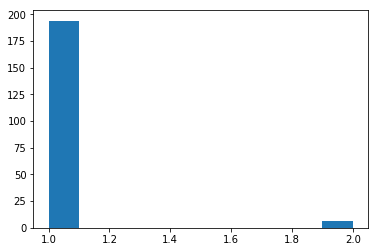

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016558170318603516
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015897035598754883
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.016117095947265625
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.01470184326171875
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.015575885772705078
Number of cells:  3  agents:  200  Frame:  2500 . Time to run last frame:  0.014672994613647461
final_state:  2.0


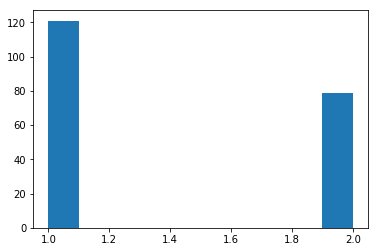

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016436100006103516
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.013416051864624023
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.014609098434448242
final_state:  1.0


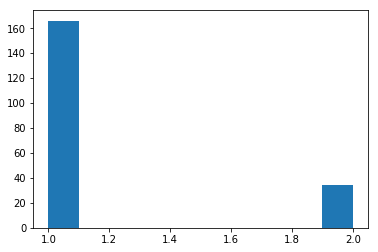

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.01695704460144043
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.018279075622558594
final_state:  2.0


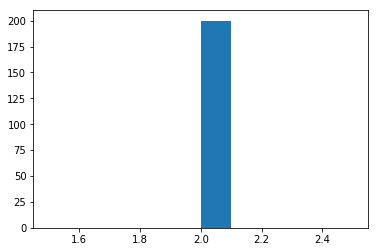

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.01651787757873535
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.014729022979736328
final_state:  1.0


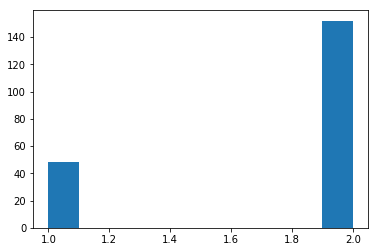

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.020939111709594727
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015674114227294922
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.014280080795288086
final_state:  1.0


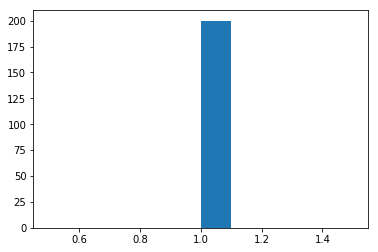

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.017030954360961914
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015556097030639648
final_state:  2.0


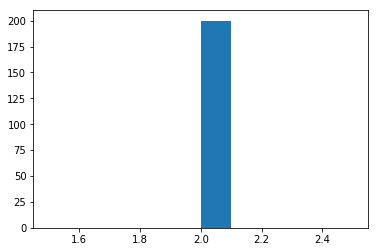

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016329050064086914
final_state:  1.0


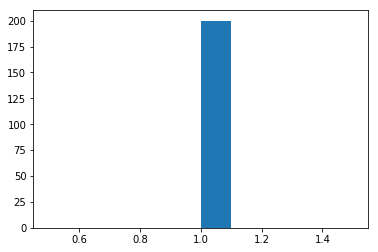

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016893863677978516
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.01585078239440918
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.016000032424926758
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.015861988067626953
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.018501996994018555
Number of cells:  3  agents:  200  Frame:  2500 . Time to run last frame:  0.014522075653076172
Number of cells:  3  agents:  200  Frame:  3000 . Time to run last frame:  0.014654874801635742
Number of cells:  3  agents:  200  Frame:  3500 . Time to run last frame:  0.015604972839355469
Number of cells:  3  agents:  200  Frame:  4000 . Time to run last frame:  0.014806985855102539
final_state:  2.0


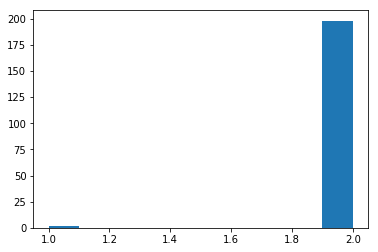

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016765832901000977
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015616893768310547
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.013776779174804688
final_state:  1.0


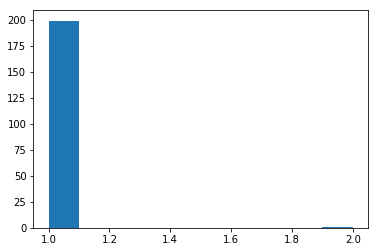

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.017416000366210938
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015970945358276367
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.013653039932250977
final_state:  2.0


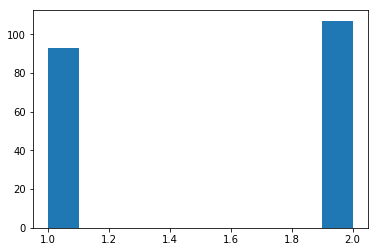

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016621112823486328
final_state:  1.0


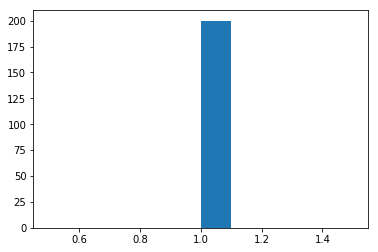

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.01686382293701172
final_state:  1.0


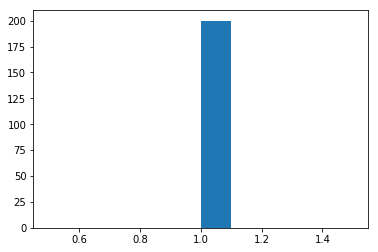

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.0164949893951416
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.01607799530029297
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.015506982803344727
final_state:  2.0


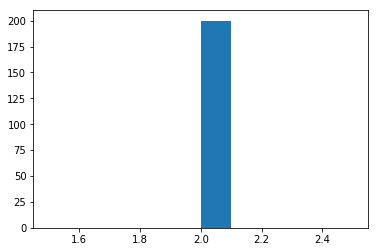

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.018212080001831055
final_state:  2.0


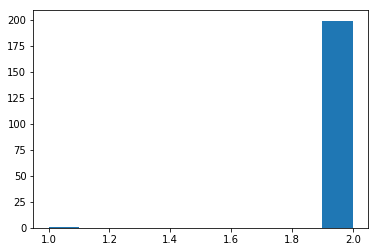

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.017223834991455078
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015690088272094727
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.015810012817382812
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.014734983444213867
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.013827085494995117
Number of cells:  3  agents:  200  Frame:  2500 . Time to run last frame:  0.013597965240478516
Number of cells:  3  agents:  200  Frame:  3000 . Time to run last frame:  0.014878034591674805
Number of cells:  3  agents:  200  Frame:  3500 . Time to run last frame:  0.013792037963867188
final_state:  1.0


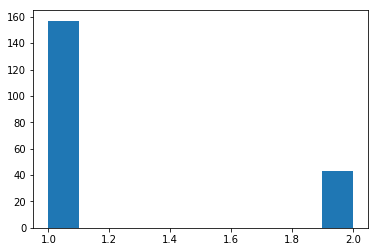

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016642093658447266
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015759944915771484
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.01565408706665039
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.014505147933959961
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.013543844223022461
Number of cells:  3  agents:  200  Frame:  2500 . Time to run last frame:  0.011687040328979492
final_state:  2.0


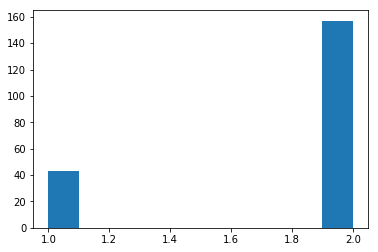

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.017528057098388672
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.01514577865600586
final_state:  1.0


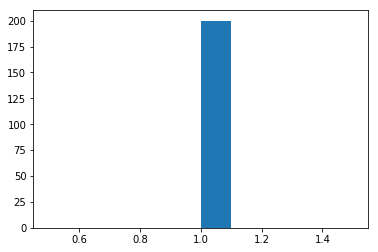

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.017941951751708984
final_state:  1.0


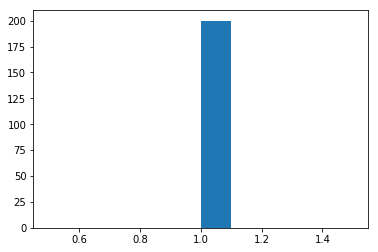

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016257047653198242
final_state:  1.0


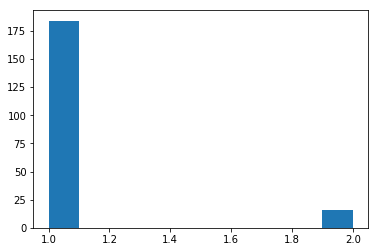

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016582965850830078
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.013645172119140625
final_state:  2.0


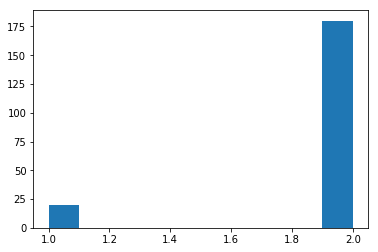

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.01650094985961914
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.014661073684692383
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.013874053955078125
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.014698028564453125
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.015261173248291016
final_state:  1.0


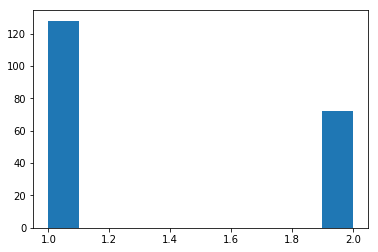

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016525983810424805
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015659093856811523
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.01581716537475586
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.01801896095275879
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.015661001205444336
Number of cells:  3  agents:  200  Frame:  2500 . Time to run last frame:  0.014717817306518555
Number of cells:  3  agents:  200  Frame:  3000 . Time to run last frame:  0.015800952911376953
Number of cells:  3  agents:  200  Frame:  3500 . Time to run last frame:  0.014728069305419922
Number of cells:  3  agents:  200  Frame:  4000 . Time to run last frame:  0.014550924301147461
Number of cells:  3  agents:  200  Frame:  4500 . Time to run last frame:  0.014620780944824219
final_state:  1.0


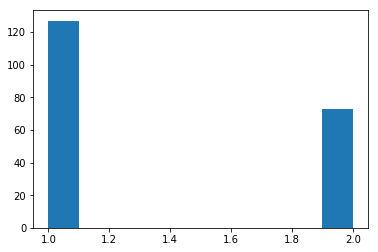

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.018728971481323242
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.01476597785949707
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.01705789566040039
final_state:  2.0


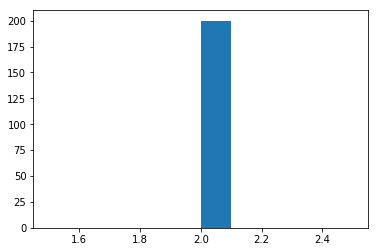

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.01665496826171875
final_state:  2.0


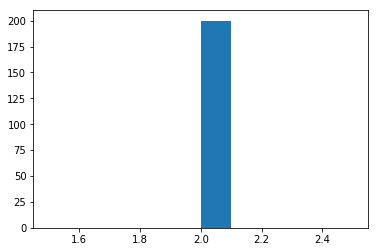

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.017625093460083008
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.015905141830444336
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.0153961181640625
Number of cells:  3  agents:  200  Frame:  1500 . Time to run last frame:  0.016041040420532227
Number of cells:  3  agents:  200  Frame:  2000 . Time to run last frame:  0.01483297348022461
final_state:  2.0


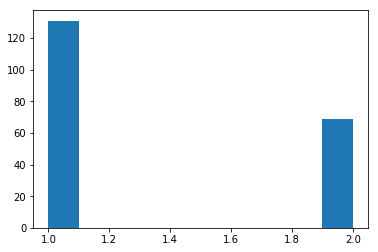

Number of cells:  3  agents:  200  Frame:  0 . Time to run last frame:  0.016505002975463867
Number of cells:  3  agents:  200  Frame:  500 . Time to run last frame:  0.014692068099975586
Number of cells:  3  agents:  200  Frame:  1000 . Time to run last frame:  0.015865087509155273


RuntimeError: index out of range at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:277

In [19]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
random.seed()

total_frames = 10000

# simulation = Simulation(num_agents=100, arena_size=800, number_of_cells=1, 
#                         body_size=1.0, video=False)

time_segment = 0
time_main = 0
time_draw = 0

#fps = []
#num_agents_list = list(range(1,3100, 100))

num_agents_list = [200]


number_cells = 3

convergence_threshold = 100
convergence_count = 0

#Simulation starts HERE
for num_agents in num_agents_list:
    final_states = []
    for trial in range(100):
        simulation = Simulation(num_agents=num_agents, arena_size=500, number_of_cells=number_cells, 
                                body_size=3.0, video=False, speed=3, state_threshold=.5, number_of_states = 2,
                                noise_sd = 1.0)
        time_start = time.time()
        for frame in range(total_frames):
            t = time.time()
            simulation.segment_individuals()
            time_segment += time.time() - t

            t = time.time()
            converged = simulation.main_graph()
            if converged:
                convergence_count += 1
            else:
                convergence_count = 0

            if frame % 500 == 0:
                print('Number of cells: ', simulation.number_of_cells, ' agents: ' ,num_agents, ' Frame: ', frame, '. Time to run last frame: ', time.time() - t)
        #    if frame == 50:
        #         %lprun -f simulation.main_graph simulation.main_graph()
            time_main += time.time() - t

            if frame % 100 == 0:
                kill = simulation.graphics()

                time_draw += time.time() - t
            

            if kill or convergence_count > convergence_threshold:
                close_cv2()
                break
        
        agents = simulation.get_agents()
        agents_states = [a.state for a in agents]
        final_states.append(agents_states)
        print('final_state: ', agents_states[0])
        plt.hist(agents_states)
        plt.show()
        

        total_time = time.time() - time_start 
        #print('total time: ', total_time)
#         print('number of cells: ', number_cells, ' averaged over ', total_frames, 'frames') 
#         print('frames per second: ', frame / total_time )
        #fps.append(frame / total_time)
        close_cv2()

        
#         print('time_segment: ', time_segment/frame )
#         print('time_main: ', time_main/frame )
#         print('time_draw: ', time_draw/frame )

plt.hist(list(itertools.chain(*final_states)))
plt.show()

([array([  35.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  165.]),
  array([   7.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  193.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  200.]),
  array([ 197.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    3.]),
  array([  58.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  142.]),
  array([ 135.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   65.]),
  array([  27.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  173.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  200.]),
  array([  23.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  177.]),
  array([ 177.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   23.]),
  array([  23.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  177.]),
  array([  65.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  135.]),
  array([   0.,    0.,    0.

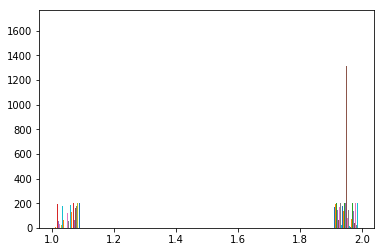

In [16]:
#final_states_combined = final_states_one.append(final_states)
#plt.hist(list(itertools.chain(*final_states_combined)))
# for s in final_states:
#     final_states_one.append(s)
plt.hist(final_states_one)

number of cells:  4  averaged over  1000 frames
frames per second:  31.73017186519486
time_segment:  0.0007815835950849531
time_main:  0.015525325043900712
time_draw:  0.022788058291445742

number of cells:  3  averaged over  1000 frames
frames per second:  32.79151068639921
time_segment:  0.0007430132444914397
time_main:  0.014550500923210197
time_draw:  0.022306745355432336

frames per second:  29.655879675925917
time_segment:  0.0007562055005444898
time_main:  0.017742341941780038
time_draw:  0.02393502874059362


number of cells:  3
frames per second:  29.48644422272298
time_segment:  0.001037949892743748
time_main:  0.02353778316747004
time_draw:  0.020952736313019565

number of cells:  5
frames per second:  24.803366419492477
time_segment:  0.0012346465012122844
time_main:  0.03040326874831627
time_draw:  0.023716416852227574

number of cells:  4
frames per second:  28.019702163948505
time_segment:  0.0012530293957940463
time_main:  0.025946830881053005
time_draw:  0.02144323546310951

number of cells:  3
frames per second:  29.022959274977296
time_segment:  0.0011627591889480065
time_main:  0.02492112948976714
time_draw:  0.020720440765907025

number of cells:  2
frames per second:  20.164164246471493
time_segment:  0.0012361016766778354
time_main:  0.03989061815985318
time_draw:  0.02851389194356984

number of cells:  1
frames per second:  6.142715544444598
time_segment:  0.001108350424930967
time_main:  0.15355000824763856
time_draw:  0.08545905968238568

Number of cells:  20  agents:  300  Frame:  600 . Time to run last frame:  0.17082500457763672
frames per second:  5.519612712467084
time_segment:  0.0017161795680273927
time_main:  0.1711822569114456
time_draw:  0.09383378895226126

Number of cells:  5  agents:  300  Frame:  600 . Time to run last frame:  0.030102014541625977
frames per second:  26.114778797024844
time_segment:  0.0011802128967809064
time_main:  0.02893639770529642
time_draw:  0.022445485656694623

Number of cells:  1  agents:  300  Frame:  600 . Time to run last frame:  0.14960217475891113
frames per second:  6.272247806402779
time_segment:  0.001048481686091389
time_main:  0.1501690915043603
time_draw:  0.08331451122682323

In [55]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(num_agents_list,fps[62:124:2])
plt.plot(num_agents_list,one_cell_fps[:62:2])
plt.plot(num_agents_list,one_cell_fps[124::2])

fps[64]

NameError: name 'fps' is not defined

In [3]:
simulation.segment_individuals()
len(simulation.cell_to_positions)

6889

In [3]:
EPSILON = .0000001
total_agents = 400
number_of_states = 10  

#Simulation start time
t1 = time.clock()
#Random generator engine from a time-based seed
random.seed()

#Set parameters

arena_size = 1000
top_left = np.array([0.0,0.0])
bottom_right = np.array([arena_size,arena_size])


sight_num = 166  #make even


max_turning_rate = 114.5
body_size = 4.0
zoa = 12.0 * body_size
zor = 2.0 * body_size
zoo = 12.0 * body_size 
speed = 10
color = [255,135,71]

angular_error_sd = 0.0

ko = 0.25
ka = 0.25


agents = []


#Simulation starts HERE

#Set up agents
for indx_agents in range(total_agents):
    # needs to be a unit vector
    set_direction = np.array([1.0, 0.0])    
    set_direction = rotate(set_direction, random.random()*360.0)
    set_r_center = random_bounded_point(bottom_right, top_left)
    state = np.random.choice(np.arange(number_of_states))


    agents.append(Individual(set_r_center, set_direction, max_turning_rate,
                             speed, zoa, zoo, zor, angular_error_sd, 
                             body_size, state, ko, ka))

for indx_j in itertools.count():

    move_agents(arena_size, zoa, agents)


    #draw to screen
    if indx_j % 1 == 0:
        kill = graphics(arena_size, agents, zoa)

    if kill:
        close_cv2()
        break

NameError: name 'random_bounded_point' is not defined

In [1]:
test = [[] for _ in range(10)]
for indx in range(10):
    for indy in range(indx):
        test[indx].append([indx,indy])
        
    

In [2]:
print(test)

[[], [[1, 0]], [[2, 0], [2, 1]], [[3, 0], [3, 1], [3, 2]], [[4, 0], [4, 1], [4, 2], [4, 3]], [[5, 0], [5, 1], [5, 2], [5, 3], [5, 4]], [[6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5]], [[7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]], [[8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7]], [[9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8]]]


In [9]:
import torch
import numpy as np
np_array = np.concatenate((np.array(t) for t in test))
torch_np_array = torch.FloatTensor(np_array)
test_array = torch.cat((torch.FloatTensor(t) for t in test))
print(test_array)
print(torch_np_array)

TypeError: The first input argument needs to be a sequence

In [1]:
import torch
import numpy as np
import time

size = 10000
test = [[] for _ in range(size)]
for indx in range(size):
    for indy in range(400):
        test[indx].append([indx,indy])

first = False
runs = 5
time_sum = 0
for run in range(runs):
    t1 = time.time()
    for t in test:
        if t:
            x = torch.cuda.FloatTensor(t)
            #x = torch.FloatTensor(t)
            #np_array = x.numpy()
            #x = np.array(t)
            #print(x.shape)
    total = time.time() - t1
    print(total)
    time_sum += total
print('sum: ' , time_sum / runs)
    


16.9633686542511
15.817723274230957
15.796191453933716
15.847870588302612
15.786517143249512
sum:  16.042334222793578


10000:
torch: 1.2947082757949828

In [9]:
%timeit torch.FloatTensor(list(range(150))).cuda()

11.4 µs ± 46.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
import torch

original_list_1 = []
for i in range(10):
    original_list_1.append(np.array([i,i/2]))
print(type(original_list_1[0]))
original_list_2 = []
for i in range(10):
    original_list_2.append(np.array([i/5,i/3]))
print(original_list_2)
tensor = torch.cat([torch.FloatTensor(original_list_1), torch.FloatTensor(original_list_2)])
print(tensor)

second_list_1 = []
for i in range(10):
    second_list_1.append(tensor[i].numpy())
    
second_list_2 = []
for i in range(10):
    second_list_2.append(tensor[i+10].numpy().astype(dtype='float64'))
    
    
print(second_list_2)

<class 'numpy.ndarray'>
[array([ 0.,  0.]), array([ 0.2       ,  0.33333333]), array([ 0.4       ,  0.66666667]), array([ 0.6,  1. ]), array([ 0.8       ,  1.33333333]), array([ 1.        ,  1.66666667]), array([ 1.2,  2. ]), array([ 1.4       ,  2.33333333]), array([ 1.6       ,  2.66666667]), array([ 1.8,  3. ])]

 0.0000  0.0000
 1.0000  0.5000
 2.0000  1.0000
 3.0000  1.5000
 4.0000  2.0000
 5.0000  2.5000
 6.0000  3.0000
 7.0000  3.5000
 8.0000  4.0000
 9.0000  4.5000
 0.0000  0.0000
 0.2000  0.3333
 0.4000  0.6667
 0.6000  1.0000
 0.8000  1.3333
 1.0000  1.6667
 1.2000  2.0000
 1.4000  2.3333
 1.6000  2.6667
 1.8000  3.0000
[torch.FloatTensor of size 20x2]

[array([ 0.,  0.]), array([ 0.2       ,  0.33333334]), array([ 0.40000001,  0.66666669]), array([ 0.60000002,  1.        ]), array([ 0.80000001,  1.33333337]), array([ 1.        ,  1.66666663]), array([ 1.20000005,  2.        ]), array([ 1.39999998,  2.33333325]), array([ 1.60000002,  2.66666675]), array([ 1.79999995,  3.     

In [24]:
bottom = (10%4 == 1)
print(bottom)

False


In [62]:
from operator import itemgetter
print(itemgetter(2,5)(test_list))
print(test_list[1:3])

import torch
test = torch.FloatTensor([1,2,3,4,5])
test = test.cuda()

([1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6])
[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]]


In [59]:


number_of_cells = 4

center_cell = 15

total_cells = number_of_cells * (number_of_cells) 

bottom = (center_cell % number_of_cells == number_of_cells - 1)
top = (center_cell % number_of_cells == 0)
left = (center_cell < number_of_cells)
right = (center_cell >= number_of_cells * (number_of_cells - 1))

print(top, bottom, left, right)

cells = []

for x in range(-1,2):
    for y in range(-1,2):
        x_adjusted = x
        y_adjusted = y
        
        if bottom and y == 1:
            x_adjusted -= 1
        if top and y == -1:
            x_adjusted += 1
            
        cell = center_cell + x_adjusted * number_of_cells + y_adjusted
        
        if right and x == 1:
            cell -= total_cells
        if left and x == -1:
            cell += total_cells
        cells.append(cell)
print(cells)

False True False True
[10, 11, 8, 14, 15, 12, 2, 3, 0]


In [ ]:
    # Part 2: Compute interactions
    for cell_x  in range(number_of_cells):
        for cell_y in range(number_of_cells):
           
            cell_id = cell_x * number_of_cells + cell_y
            if cell_to_agents_list[cell_id] != -1:

                for neighbor_x in range(cell_x - 1, cell_x + 2):
                    for neighbor_y in range(cell_y - 1, cell_y + 2):
                    
                        periodic_adjusted_x = neighbor_x;
                        periodic_adjusted_y = neighbor_y;
                        
                        if neighbor_x < 0:
                            periodic_adjusted_x += number_of_cells 
                        elif neighbor_x >= number_of_cells:
                            periodic_adjusted_x -= number_of_cells
                        
                        if neighbor_y < 0:
                            periodic_adjusted_y += number_of_cells
                        elif neighbor_y >=number_of_cells:
                            periodic_adjusted_y -= number_of_cells
                        
                        neighbor_cell_id = periodic_adjusted_x * number_of_cells + periodic_adjusted_y
                        
                        focal_agent_id = cell_to_agents_list[cell_id]
                        
                        while focal_agent_id != -1:
                            neighbor_agent_id = cell_to_agents_list[neighbor_cell_id]
                            
                            while neighbor_agent_id != -1:
                                if focal_agent_id != neighbor_agent_id:
                                    compute_social_forces(
                                        int(focal_agent_id), int(neighbor_agent_id), agents, arena_size)     
                                neighbor_agent_id = agents_to_agents_list[neighbor_agent_id]
                            focal_agent_id = agents_to_agents_list[focal_agent_id];

In [43]:
test = torch.cuda.FloatTensor()

In [44]:
test

[torch.cuda.FloatTensor with no dimension]

In [45]:
test.size()

torch.Size([])

In [46]:
if test.size():
    print('here')
else:
    print('Herer')

Herer


In [20]:
list(range(1,2100, 100))

[1,
 101,
 201,
 301,
 401,
 501,
 601,
 701,
 801,
 901,
 1001,
 1101,
 1201,
 1301,
 1401,
 1501,
 1601,
 1701,
 1801,
 1901]

In [2]:
import kogers_colors

In [4]:
kogers_colors.Colors()

AttributeError: module 'kogers_colors' has no attribute 'Colors'

In [6]:
body_scale = 3
arena_size = 1000
num_agents = 500
colors = [kc.red(), kc.ivory()]

for frame in range(200):
    visualization = (np.ones((arena_size, arena_size, 3), np.uint8) *
                     kc.blueberry_slate('np.uint8'))

    # for i in range(len(self.agents)):
    #     color = colors[int(self.agents[i].state)]
    #     position = tuple(self.agents[i].r_center.astype(int))
    #     scaled_body_size = self.agents[i].body_size * body_scale

    #     cv2.circle(visualization, position, 
    #                int(scaled_body_size), 
    #                color, -1, cv2.LINE_AA)

    #     cv2.line(visualization, position, 
    #              tuple((position - self.agents[i].direction * 3 *
    #                   scaled_body_size).astype(int)), 
    #              color, 1, cv2.LINE_AA)

    t = time.time()
    for i in range(num_agents):
        color = colors[0]
        position = np.random.randint(0, arena_size, 2)
        direction = np.random.randint(0, 1, 2)
        scaled_body_size = body_scale

        #print(position)
        cv2.circle(visualization, tuple(position), 
                   int(scaled_body_size), 
                   color, -1, cv2.LINE_AA)

        cv2.line(visualization, tuple(position), 
                 tuple((position - direction * 3 *
                      scaled_body_size).astype(int)), 
                 color, 1, cv2.LINE_AA)
    
    
    print('1: ', time.time() - t) 
    t = time.time()
    visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
    
    cv2.imshow("decision_making", visualization)
    print('2: ', time.time() - t)

    cv2.waitKey(1)
    
close_cv2()

1:  0.015626907348632812
2:  0.010530948638916016
1:  0.008996009826660156
2:  0.005769014358520508
1:  0.011281013488769531
2:  0.0070879459381103516
1:  0.008906126022338867
2:  0.006660938262939453
1:  0.008717060089111328
2:  0.0064220428466796875
1:  0.008951187133789062
2:  0.006020069122314453
1:  0.008910179138183594
2:  0.006112098693847656
1:  0.008682966232299805
2:  0.007230997085571289
1:  0.009557008743286133
2:  0.007122993469238281
1:  0.009327888488769531
2:  0.006536006927490234
1:  0.009304046630859375
2:  0.0063991546630859375
1:  0.009705066680908203
2:  0.00633692741394043
1:  0.009421110153198242
2:  0.006706953048706055
1:  0.008504152297973633
2:  0.006105899810791016
1:  0.008966922760009766
2:  0.00613093376159668
1:  0.008933782577514648
2:  0.006200075149536133
1:  0.008679866790771484
2:  0.0057599544525146484
1:  0.008912086486816406
2:  0.006822109222412109
1:  0.008798837661743164
2:  0.006639003753662109
1:  0.009093999862670898
2:  0.00699901580810546

In [89]:
x = torch.zeros((10,10))
for i in range(x.size()[0]):
    for j in range(x.size()[1]):
        x[i, j] = i*j
print(x)


    0     0     0     0     0     0     0     0     0     0
    0     1     2     3     4     5     6     7     8     9
    0     2     4     6     8    10    12    14    16    18
    0     3     6     9    12    15    18    21    24    27
    0     4     8    12    16    20    24    28    32    36
    0     5    10    15    20    25    30    35    40    45
    0     6    12    18    24    30    36    42    48    54
    0     7    14    21    28    35    42    49    56    63
    0     8    16    24    32    40    48    56    64    72
    0     9    18    27    36    45    54    63    72    81
[torch.FloatTensor of size 10x10]



In [90]:
c, x_max = torch.max(x, 1)

In [91]:
print(x_max)
print(c)


 0
 9
 9
 9
 9
 9
 9
 9
 9
 9
[torch.LongTensor of size 10]


  0
  9
 18
 27
 36
 45
 54
 63
 72
 81
[torch.FloatTensor of size 10]



In [25]:
num_states = 2
x1 = torch.ones(5,3)
x1[2,2] = 0
x1 = torch.unsqueeze(x1, 2)
x1 = x1.repeat(1, 1, num_states)
x2 = torch.arange(0,num_states)

result = torch.eq(x1, x2)


In [29]:
print(result)
y = torch.sum(result, 0) 
print(y)
_, test = torch.max(y, 1)
print(test)


(0 ,.,.) = 
  0  1
  0  1
  0  1

(1 ,.,.) = 
  0  1
  0  1
  0  1

(2 ,.,.) = 
  0  1
  0  1
  1  0

(3 ,.,.) = 
  0  1
  0  1
  0  1

(4 ,.,.) = 
  0  1
  0  1
  0  1
[torch.ByteTensor of size 5x3x2]


 0  5
 0  5
 1  4
[torch.ByteTensor of size 3x2]


 1
 1
 1
[torch.LongTensor of size 3]



In [23]:
t = torch.ones((5,3))
t[1,1] = 3
t[1,0] = 0
t[3,0] = 4


states = torch.arange(1, t.size()[1] + 1)
# states = torch.unsqueeze(states, 0)
# states = states.repeat(t.size()[0], 1)

t_max, _ = torch.max(t, 1)
t_max = torch.unsqueeze(t_max, 1)
t_max = t_max.repeat(1,t.size()[1])
print(t.size(), t_max.size())
mask = (t==t_max).type(torch.FloatTensor)
mask_sum = torch.sum(mask, 1)
mask_cumsum = torch.cumsum(mask_sum, 0)
rand = torch.rand(t.size()[0])
rand_ind = (mask_sum * rand).type(torch.FloatTensor)

possible_states = torch.nonzero(mask * states)
print(possible_states[:,0])
possible = states[possible_states[:,0], possible_states[:,1]]
state_ind = mask_cumsum - rand_ind
# print(t)
# print(t_max)
# print(t==t_max)
# print(mask * t)
print(possible)
print(mask_cumsum)
print(rand_ind)
print(state_ind)
print(possible[state_ind.type(torch.LongTensor)])


torch.Size([5, 3]) torch.Size([5, 3])

 0
 0
 0
 1
 2
 2
 2
 3
 4
 4
 4
[torch.LongTensor of size 11]



IndexError: trying to index 2 dimensions of a 1 dimensional tensor

#### r = torch.rand(10)

In [88]:
r


 0.5143
 0.5374
 0.9312
 0.9167
 0.6380
 0.8383
 0.9238
 0.9369
 0.6605
 0.8678
[torch.FloatTensor of size 10]

In [12]:
test = [[1,2,3,4,5] for _ in range(10)]

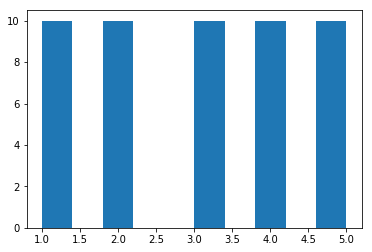

In [16]:
merged = list(itertools.chain(*test))
plt.hist(merged)
plt.show()

In [103]:

test = pd.DataFrame(columns=['i', 'j', 'k'], dtype=int)
test.loc[3] = {'i':int(1), 'j':int(23), 'k':int(12)}
test.loc[1] = [4, 3,1]

In [104]:
test

,i,j,k
3,1.0,23.0,12.0
1,4.0,3.0,1.0


In [105]:
one = 10
two = 234
test.loc[3, ['i', 'j']] = [one, two]
test.at[1, 'k'] = one

In [106]:
test.loc[1]['i']

4.0

In [107]:
test

,i,j,k
3,10.0,234.0,12.0
1,4.0,3.0,10.0


In [17]:
one = [1,2,3,4,0]
two = [7,8,9,10,11]

In [22]:
test = two[one[0]:]

In [27]:
import torch
test = torch.FloatTensor([1,2,3,4,5])
test2 = torch.FloatTensor([1,2,3,4,5])

In [28]:
test[test2.type(torch.LongTensor)]

RuntimeError: index out of range at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:277

In [4]:
int(.7)

0

In [5]:
int(.99999999999999)

0

In [6]:
int(1)

1

In [7]:
int(.99999999999999999999999999999999999999999999999999999999999)

1

In [8]:
int(1-3.6578e-07)

0

In [30]:
test = 30-3.6578e-05

In [11]:
test.type(torch.LongTensor)


AttributeError: 'float' object has no attribute 'type'

In [31]:
testone = torch.FloatTensor([test])

In [32]:
testone.type(torch.LongTensor)


 29
[torch.LongTensor of size 1]

In [38]:
int(float(30-3.6578e-07)) 

29

In [37]:
torch.FloatTensor([30-3.6578e-07]).type(torch.LongTensor)


 29
[torch.LongTensor of size 1]

In [43]:
torch.ceil(torch.FloatTensor([3.6578e-20]))


 1
[torch.FloatTensor of size 1]

In [49]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
   ...:                           'foo', 'bar', 'foo', 'foo'],
   ...:                    'B' : ['one', 'one', 'two', 'three',
   ...:                           'two', 'two', 'one', 'three'],
   ...:                    'C' : list(range(8)),
   ...:                    'D' : list(range(8,16))})

In [55]:
print(df)
df.groupby(['A','B']).mean()

     A      B  C   D
0  foo    one  0   8
1  bar    one  1   9
2  foo    two  2  10
3  bar  three  3  11
4  foo    two  4  12
5  bar    two  5  13
6  foo    one  6  14
7  foo  three  7  15


C   D
A   B           
bar one    1   9
    three  3  11
    two    5  13
foo one    3  11
    three  7  15
    two    3  11